<a href="https://colab.research.google.com/github/djhshih/rxrx-covid/blob/main/explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 # Background

Our high throughput screening team conducts experiments where we image cells in 1536-well plates.  Cells isolated in each well are exposed to a specific set of conditions.   In this dataset, we have exposed human renal cortical epithelial cells (HRCE) and African green monkey kidney epithelial cells (Vero) to active and UV-inactivated Covid19 virus.  For each well in the plate, we image 4 tiled locations (which may overlap), referred to as sites.  Once the images are collected, we transform them into embeddings using our own internal deep learning model.  This effectively reduces the information content of each image into 1024 features which can be used to perform your analysis.

To summarize, we have:
- two cell types (HRCE and Vero)
- four independent experiments (two per cell type), each consisting of multiple plates
- 1536 wells per plate
- 2 disease condiations:  active or UV-inactivated Covid19 virus
- 4 sites imaged per well
- embeddings (i.e. features) for each site image

# Objective

Above we've described a **heterogeneous data set** obtained from multiple cell types and experiments that we expect to be systematically different from one another in our feature space due to both intrinsic and environmental factors. We ultimately want to be able to use this data to build a single model that distinguishes between healthy and diseased cells, and that is broadly applicable to new data for either cell type. **Your objective here is to normalize, combine and otherwise prepare this data to be used in a single modeling task, including the creation of a simple train/test split.**  

You may assume that any new data obtained will include a set of disease and healthy controls (in addition to wells of unknown condition, which your model will score).


<img src="https://www.brookslifesciences.com/sites/default/files/products/4titude/plates-microplates/pcr-plates/4ti-1384-384-well-skirted-pcr-plate/carousel/4ti-1384_front.jpg">

# Solution
## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as pl
import sklearn as sk
import numpy as np
from combat.pycombat import pycombat
from plotnine import *
from sklearn.decomposition import PCA
import random

## Read in Data

In [3]:
sample_data = pd.read_csv('https://storage.googleapis.com/rxrx-sample-data/sample_data.csv')
metadata_cols = ['site_id', 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition']
sample_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
sample_data.columns

Index(['site_id', 'well_id', 'cell_type', 'experiment', 'plate', 'well',
       'site', 'disease_condition', 'feature_0', 'feature_1',
       ...
       'feature_1014', 'feature_1015', 'feature_1016', 'feature_1017',
       'feature_1018', 'feature_1019', 'feature_1020', 'feature_1021',
       'feature_1022', 'feature_1023'],
      dtype='object', length=1032)

In [5]:
sample_data.describe()

,plate,site,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
count,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,...,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000
mean,12.844634,2.500000,2.006144,-0.007130,-0.451248,-0.049758,-0.677963,0.551251,0.165530,-0.070577,...,0.563596,0.998113,-0.999028,-1.049231,-1.335464,-0.010090,-0.057984,0.397072,-0.320275,-1.531284
std,8.781688,1.118055,0.733912,0.293988,0.554078,0.440601,0.340155,0.300528,0.296025,0.392564,...,0.454366,0.390222,0.548680,0.338161,0.268669,0.347330,0.793472,0.586613,0.388031,0.484943
min,1.000000,1.000000,-0.702054,-1.343151,-2.586355,-2.256134,-2.569241,-0.958506,-1.251047,-1.705803,...,-1.274248,-0.829056,-2.087945,-2.247251,-2.524826,-1.465479,-1.913825,-0.956811,-2.691734,-3.947018
25%,4.000000,1.750000,1.943538,-0.224182,-0.787247,-0.349187,-0.928951,0.369902,-0.023623,-0.250037,...,0.441552,0.708989,-1.335685,-1.273948,-1.503679,-0.233051,-0.525224,0.046181,-0.496035,-1.719856
50%,13.000000,2.500000,2.229050,-0.008094,-0.425181,-0.107183,-0.686082,0.571076,0.168334,-0.016465,...,0.684685,0.978300,-1.154678,-1.044347,-1.357710,-0.046214,-0.288426,0.217894,-0.269833,-1.450118
75%,21.000000,3.250000,2.459342,0.202377,-0.012851,0.217806,-0.437504,0.757195,0.355926,0.192182,...,0.858676,1.302032,-0.924973,-0.822082,-1.184041,0.156779,0.001494,0.445660,-0.068681,-1.223803
max,27.000000,4.000000,3.441292,1.486336,1.300483,1.700230,0.647875,1.635633,1.708363,0.959271,...,1.612077,2.428050,1.110015,0.603096,0.038859,1.587163,2.879538,3.463884,0.801364,0.940488


In [6]:
sample_data.experiment

0        HRCE-1
1        HRCE-1
2        HRCE-1
3        HRCE-1
4        HRCE-1
          ...  
26307    VERO-2
26308    VERO-2
26309    VERO-2
26310    VERO-2
26311    VERO-2
Name: experiment, Length: 26312, dtype: object

In [7]:
sample_data.cell_type

0        HRCE
1        HRCE
2        HRCE
3        HRCE
4        HRCE
         ... 
26307    VERO
26308    VERO
26309    VERO
26310    VERO
26311    VERO
Name: cell_type, Length: 26312, dtype: object

In [8]:
sample_data.disease_condition

0        UV Inactivated SARS-CoV-2
1        UV Inactivated SARS-CoV-2
2        UV Inactivated SARS-CoV-2
3        UV Inactivated SARS-CoV-2
4        UV Inactivated SARS-CoV-2
                   ...            
26307            Active SARS-CoV-2
26308            Active SARS-CoV-2
26309            Active SARS-CoV-2
26310            Active SARS-CoV-2
26311            Active SARS-CoV-2
Name: disease_condition, Length: 26312, dtype: object

In [14]:
pd.crosstab(1, columns = [sample_data['experiment'], sample_data['disease_condition']])

experiment                   HRCE-1                            \
disease_condition Active SARS-CoV-2 UV Inactivated SARS-CoV-2   
row_0                                                           
1                              8016                      4160   

experiment                   HRCE-2                            \
disease_condition Active SARS-CoV-2 UV Inactivated SARS-CoV-2   
row_0                                                           
1                              5880                      4320   

experiment                   VERO-1                            \
disease_condition Active SARS-CoV-2 UV Inactivated SARS-CoV-2   
row_0                                                           
1                              1648                       320   

experiment                   VERO-2                            
disease_condition Active SARS-CoV-2 UV Inactivated SARS-CoV-2  
row_0                                                          
1                              1648                       320

In [21]:
pd.crosstab(sample_data['plate'], columns = [sample_data['experiment'], sample_data['disease_condition']])

experiment                   HRCE-1                            \
disease_condition Active SARS-CoV-2 UV Inactivated SARS-CoV-2   
plate                                                           
1                               216                       160   
2                               216                       160   
3                               216                       160   
4                               216                       160   
5                               216                       160   
6                               216                       160   
7                               216                       160   
8                               360                       160   
9                               216                       160   
10                              216                       160   
11                              216                       160   
12                              216                       160   
13                              216                       160   
14                              216                       160   
15                              216                       160   
16                              360                       160   
17                              216                       160   
18                              216                       160   
19                              216                       160   
20                              216                       160   
21                              216                       160   
22                              264                       160   
23                              264                       160   
24                              408                       160   
25                             1128                       160   
26                             1128                       160   
27                                0                         0   

experiment                   HRCE-2                            \
disease_condition Active SARS-CoV-2 UV Inactivated SARS-CoV-2   
plate                                                           
1                               216                       160   
2                               216                       160   
3                               216                       160   
4                               216                       160   
5                               216                       160   
6                               216                       160   
7                               216                       160   
8                               216                       160   
9                               216                       160   
10                              216                       160   
11                              216                       160   
12                              216                       160   
13                              216                       160   
14                              216                       160   
15                              216                       160   
16                              216                       160   
17                              216                       160   
18                              216                       160   
19                              216                       160   
20                              216                       160   
21                              216                       160   
22                              216                       160   
23                              216                       160   
24                              216                       160   
25                              240                       160   
26                              240                       160   
27                              216                       160   

experiment                   VERO-1                            \
disease_condition Active SARS-CoV

In [23]:
pd.crosstab(sample_data['well'], columns = [sample_data['plate']])

plate,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
well,,,,,,,,,,,,,,,,,,,,,
AA02,4,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,8,0,0
AA03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
AA04,4,4,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,8,0
AA05,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AA06,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z43,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
Z44,0,4,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Z45,0,4,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
idx = np.where(sample_data.columns == 'feature_0')[0].item()
features = sample_data.iloc[:, idx:]
features

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,2.194816,-0.105292,-0.046181,-0.161973,-1.006325,0.568540,0.572074,0.035659,0.007511,0.164367,...,0.661410,0.722917,-1.654883,-1.039532,-1.275908,-0.113406,-0.996582,0.107171,0.281750,-1.321678
1,2.095633,-0.218020,-0.127621,-0.149912,-0.780210,0.660563,0.759083,0.200471,0.130232,0.144276,...,0.900095,0.681125,-1.313322,-1.333047,-1.405456,0.115006,-0.670360,0.181035,0.014230,-1.406452
2,1.779929,0.032698,-0.462570,0.077970,-0.702946,0.595584,1.037175,0.178364,0.389227,0.248819,...,0.576713,0.433239,-1.439914,-0.509420,-1.507544,-0.226118,-0.569021,-0.038540,-0.020967,-1.349082
3,2.033882,0.134098,0.321624,-0.194107,-0.874373,0.683397,0.753974,-0.107142,0.039776,-0.143926,...,0.513103,0.430219,-1.344728,-0.839880,-1.397942,0.003676,-0.995562,0.316649,-0.460665,-0.980651
4,1.580380,0.322165,0.025902,-0.526742,-1.285394,0.258462,0.172519,0.246669,-0.012855,-0.043613,...,0.772953,0.400309,-1.327616,-0.966762,-1.308639,-0.112925,-0.430904,0.270322,-0.095949,-1.337222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26307,0.701850,-0.033388,-1.415752,0.711600,-0.304515,0.153426,0.218653,-0.773119,0.200643,0.613078,...,-0.112476,0.927443,-0.255119,-1.295004,-1.356170,0.226043,1.218617,2.253161,-0.700415,-2.607391
26308,0.829139,0.142416,-1.298933,0.624738,-0.268983,0.252319,0.280756,-0.828576,0.011077,0.907621,...,-0.526843,0.986243,-0.149056,-1.444974,-1.406689,0.453035,1.184009,1.828677,-0.762747,-2.594228
26309,0.746309,0.222922,-1.568174,0.209752,0.037875,0.540103,0.136899,-0.500103,0.181224,1.069754,...,-0.018189,0.982102,0.064325,-1.246278,-1.512279,0.652084,0.943628,1.624153,-0.150157,-2.633923
26310,0.511170,-0.011477,-1.591794,0.707624,-0.352115,0.326557,0.088157,-0.874001,-0.029327,0.437886,...,-0.442354,1.007888,-0.154602,-1.115352,-1.166031,0.253483,1.628157,1.886624,-0.954471,-2.867024


In [30]:
pheno = sample_data.iloc[:, :idx]
pheno

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition
0,HRCE-1_1_AA08_1,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,1,UV Inactivated SARS-CoV-2
1,HRCE-1_1_AA08_2,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,2,UV Inactivated SARS-CoV-2
2,HRCE-1_1_AA08_3,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,3,UV Inactivated SARS-CoV-2
3,HRCE-1_1_AA08_4,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,4,UV Inactivated SARS-CoV-2
4,HRCE-1_1_AA16_1,HRCE-1_1_AA16,HRCE,HRCE-1,1,AA16,1,UV Inactivated SARS-CoV-2
...,...,...,...,...,...,...,...,...
26307,VERO-2_2_Z43_4,VERO-2_2_Z43,VERO,VERO-2,2,Z43,4,Active SARS-CoV-2
26308,VERO-2_2_Z47_1,VERO-2_2_Z47,VERO,VERO-2,2,Z47,1,Active SARS-CoV-2
26309,VERO-2_2_Z47_2,VERO-2_2_Z47,VERO,VERO-2,2,Z47,2,Active SARS-CoV-2
26310,VERO-2_2_Z47_3,VERO-2_2_Z47,VERO,VERO-2,2,Z47,3,Active SARS-CoV-2


In [33]:
pca = PCA()
pca.fit(features.T)

PCA()

In [34]:
pca.components_.shape

(1024, 26312)

In [35]:
df = pd.concat(
  [ pheno, pd.DataFrame(pca.components_.T, columns=['pc' + str(i+1) for i in range(pca.n_components_)]) ],
  axis = 1
)
df

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition,pc1,pc2,...,pc1015,pc1016,pc1017,pc1018,pc1019,pc1020,pc1021,pc1022,pc1023,pc1024
0,HRCE-1_1_AA08_1,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,1,UV Inactivated SARS-CoV-2,-0.006849,0.001991,...,-0.003280,0.000842,-0.007266,0.001255,0.002737,-0.001815,0.001393,0.013252,-0.003048,-0.199204
1,HRCE-1_1_AA08_2,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,2,UV Inactivated SARS-CoV-2,-0.006404,0.002396,...,-0.001058,0.002192,-0.000637,0.002189,0.003850,-0.004815,-0.002121,-0.005605,0.000333,-0.037835
2,HRCE-1_1_AA08_3,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,3,UV Inactivated SARS-CoV-2,-0.006230,0.001293,...,-0.000525,-0.002311,0.003800,0.000681,-0.000339,0.002314,-0.000680,0.002145,-0.009418,-0.043190
3,HRCE-1_1_AA08_4,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,4,UV Inactivated SARS-CoV-2,-0.005962,0.000915,...,-0.001751,0.007087,-0.006309,0.006211,0.004625,-0.006416,-0.003156,-0.005264,-0.000479,-0.006377
4,HRCE-1_1_AA16_1,HRCE-1_1_AA16,HRCE,HRCE-1,1,AA16,1,UV Inactivated SARS-CoV-2,-0.006225,0.002961,...,-0.000249,0.008032,0.002692,-0.001805,0.000922,-0.001619,-0.005381,-0.008798,-0.008269,0.021829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26307,VERO-2_2_Z43_4,VERO-2_2_Z43,VERO,VERO-2,2,Z43,4,Active SARS-CoV-2,-0.003772,-0.016478,...,0.007901,0.008722,-0.005854,0.008789,0.002097,-0.002363,-0.007950,-0.000980,-0.001170,0.000590
26308,VERO-2_2_Z47_1,VERO-2_2_Z47,VERO,VERO-2,2,Z47,1,Active SARS-CoV-2,-0.003756,-0.016067,...,0.008267,0.021653,-0.011354,-0.006467,-0.001155,0.006465,-0.006254,0.010933,-0.004739,-0.000962
26309,VERO-2_2_Z47_2,VERO-2_2_Z47,VERO,VERO-2,2,Z47,2,Active SARS-CoV-2,-0.003835,-0.014986,...,0.003532,-0.006220,-0.007433,-0.006645,-0.011897,-0.001631,0.004423,0.015927,0.006084,-0.004859
26310,VERO-2_2_Z47_3,VERO-2_2_Z47,VERO,VERO-2,2,Z47,3,Active SARS-CoV-2,-0.003490,-0.016112,...,0.001581,-0.006432,-0.015914,-0.006485,0.000691,0.006843,0.001593,-0.008773,-0.015209,-0.001449


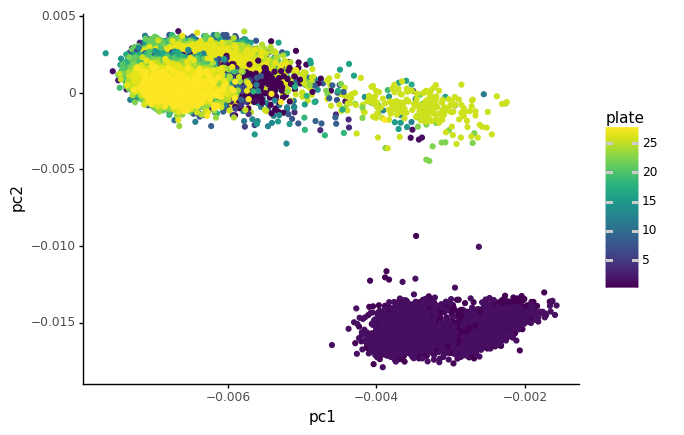

In [36]:
print(
    ggplot(df, aes(x = 'pc1', y = 'pc2', colour = 'plate')) +
      theme_classic() +
      geom_point()
)

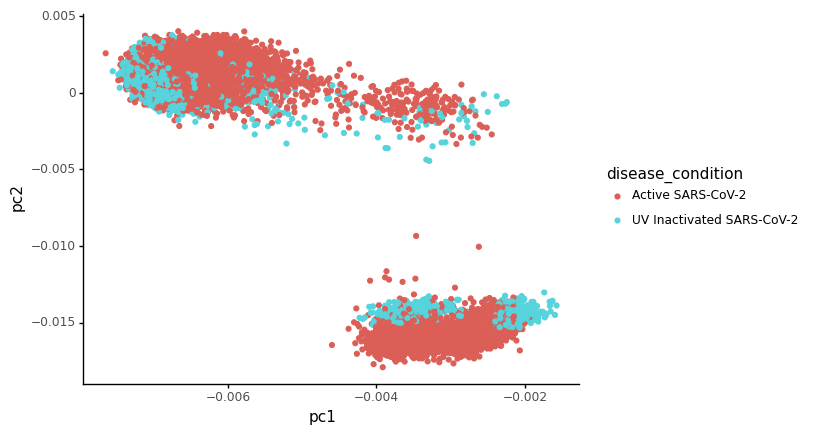

In [37]:
print(
    ggplot(df, aes(x = 'pc1', y = 'pc2', colour = 'disease_condition')) +
      theme_classic() +
      geom_point()
)

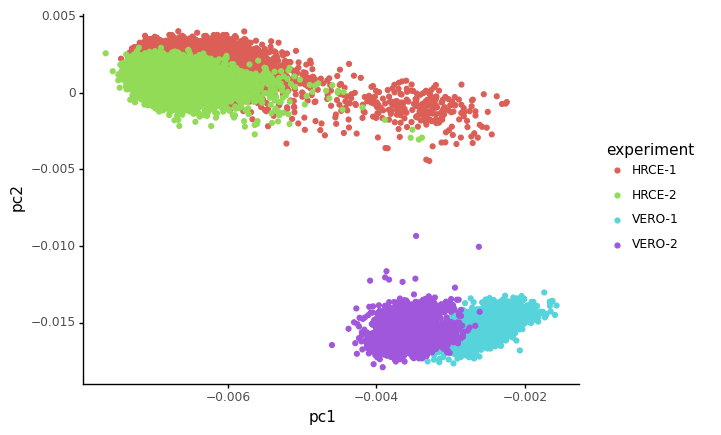

In [38]:
print(
    ggplot(df, aes(x = 'pc1', y = 'pc2', colour = 'experiment')) +
      theme_classic() +
      geom_point()
)

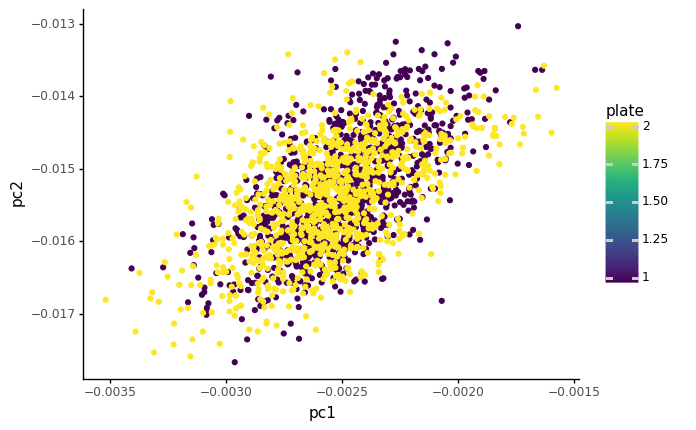

In [39]:
print(
    ggplot(df[df.experiment == 'VERO-1'], aes(x = 'pc1', y = 'pc2', colour = 'plate')) +
      theme_classic() +
      geom_point()
)

In [40]:
print(df[df.experiment == 'VERO-1'].plate.value_counts())

2    984
1    984
Name: plate, dtype: int64


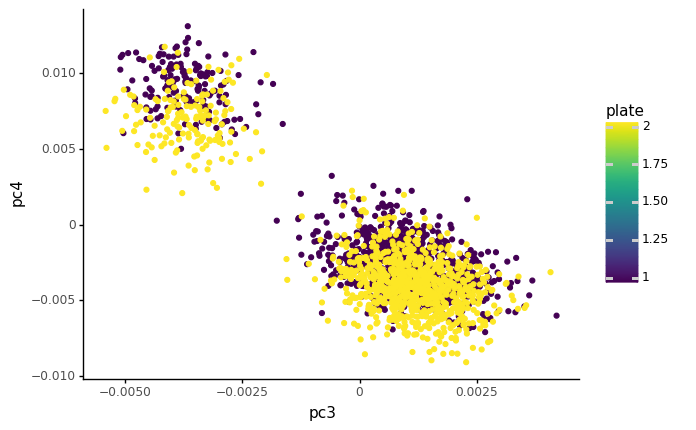

In [83]:
print(
    ggplot(df[df.experiment == 'VERO-1'], aes(x = 'pc3', y = 'pc4', colour = 'plate')) +
      theme_classic() +
      geom_point()
)

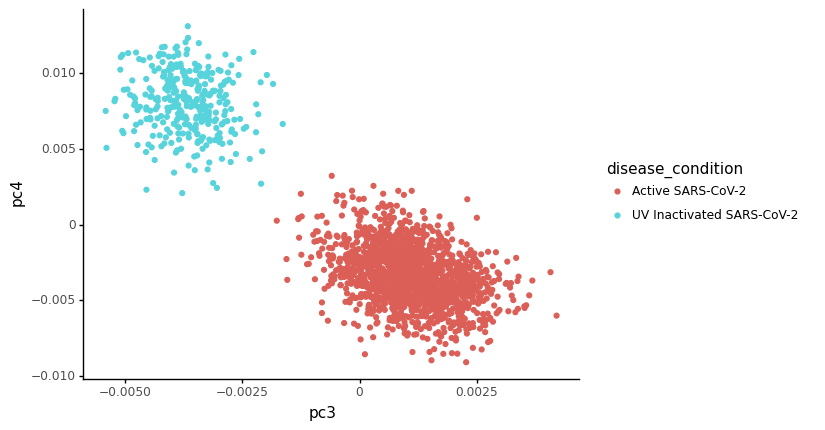

In [85]:
print(
    ggplot(df[df.experiment == 'VERO-1'], aes(x = 'pc3', y = 'pc4', colour = 'disease_condition')) +
      theme_classic() +
      geom_point()
)

In [74]:
# technical variables: experiment, plate, site
# biological variable: disease_condition
# other variable of intereset: cell_type

batch = pheno.experiment.values

In [75]:
features.shape

(26312, 1024)

In [76]:
batch.shape

(26312,)

In [77]:
features_bc = pycombat(features.T, batch)

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [78]:
pca2 = PCA()
pca2.fit(features_bc)

PCA()

In [79]:
df_bc = pd.concat(
  [ pheno, pd.DataFrame(pca2.components_.T, columns=['pc' + str(i+1) for i in range(pca2.n_components_)]) ],
  axis = 1
)
df_bc

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition,pc1,pc2,...,pc1015,pc1016,pc1017,pc1018,pc1019,pc1020,pc1021,pc1022,pc1023,pc1024
0,HRCE-1_1_AA08_1,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,1,UV Inactivated SARS-CoV-2,-0.006602,0.006521,...,0.000157,0.000522,0.001618,0.000143,0.005006,0.003796,-0.005822,0.000075,0.003217,0.112019
1,HRCE-1_1_AA08_2,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,2,UV Inactivated SARS-CoV-2,-0.006150,0.006965,...,-0.005722,-0.000744,0.004137,-0.000313,-0.000788,0.000505,0.006427,-0.004072,0.003249,0.007467
2,HRCE-1_1_AA08_3,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,3,UV Inactivated SARS-CoV-2,-0.006020,0.009261,...,0.000157,-0.000869,0.003254,-0.008768,-0.000027,-0.000631,-0.012249,0.002844,0.004605,-0.014050
3,HRCE-1_1_AA08_4,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,4,UV Inactivated SARS-CoV-2,-0.005773,0.008165,...,0.001402,-0.001805,-0.004112,-0.007810,-0.000965,-0.007030,0.009399,0.000428,-0.002606,-0.002704
4,HRCE-1_1_AA16_1,HRCE-1_1_AA16,HRCE,HRCE-1,1,AA16,1,UV Inactivated SARS-CoV-2,-0.005959,0.004673,...,0.001462,-0.006331,0.001166,0.003017,0.003073,-0.007256,-0.003005,0.006399,-0.010556,0.002816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26307,VERO-2_2_Z43_4,VERO-2_2_Z43,VERO,VERO-2,2,Z43,4,Active SARS-CoV-2,-0.006390,-0.000540,...,-0.017778,-0.002769,0.013481,0.009432,-0.006166,-0.005121,0.013045,-0.018262,-0.015687,0.007981
26308,VERO-2_2_Z47_1,VERO-2_2_Z47,VERO,VERO-2,2,Z47,1,Active SARS-CoV-2,-0.006347,0.000849,...,-0.013882,-0.003401,-0.001867,-0.002503,-0.007194,0.000657,0.019904,-0.002117,0.025297,-0.001430
26309,VERO-2_2_Z47_2,VERO-2_2_Z47,VERO,VERO-2,2,Z47,2,Active SARS-CoV-2,-0.006381,-0.001302,...,0.003229,0.003642,0.003823,0.025090,0.014243,-0.013845,-0.014742,0.004351,0.009148,-0.001887
26310,VERO-2_2_Z47_3,VERO-2_2_Z47,VERO,VERO-2,2,Z47,3,Active SARS-CoV-2,-0.006101,-0.000416,...,-0.014643,0.002723,0.002643,0.002456,0.011352,-0.007985,0.005248,0.014900,0.015743,-0.001335


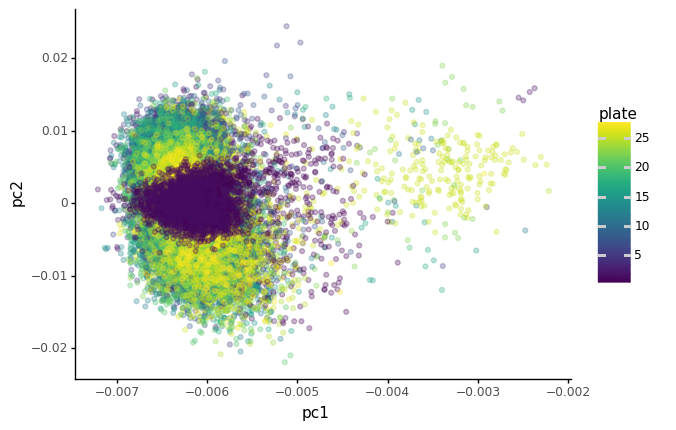

In [80]:
print(
    ggplot(df_bc, aes(x = 'pc1', y = 'pc2', colour = 'plate')) +
      theme_classic() +
      geom_point(alpha=0.3)
)

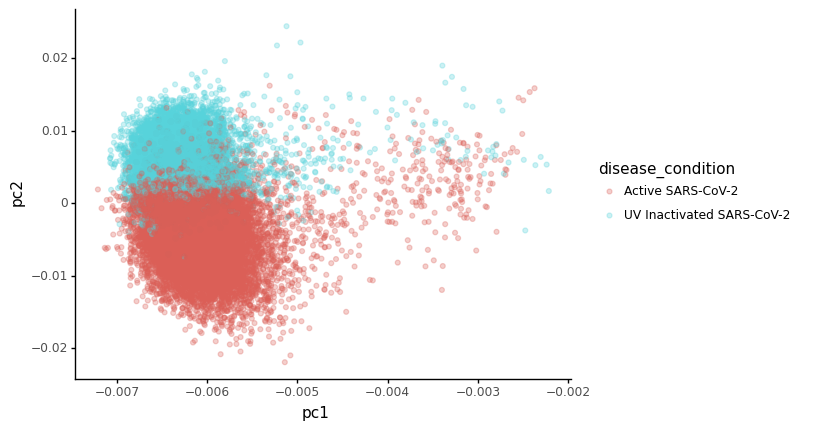

In [81]:
print(
    ggplot(df_bc, aes(x = 'pc1', y = 'pc2', colour = 'disease_condition')) +
      theme_classic() +
      geom_point(alpha=0.3)
)

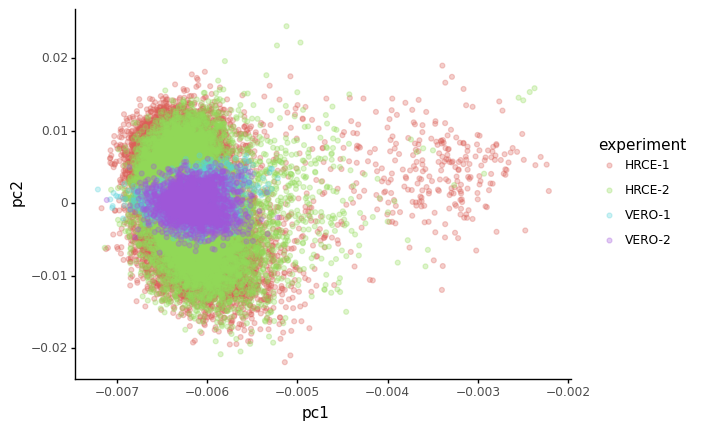

In [82]:
print(
    ggplot(df_bc, aes(x = 'pc1', y = 'pc2', colour = 'experiment')) +
      theme_classic() +
      geom_point(alpha=0.3)
)

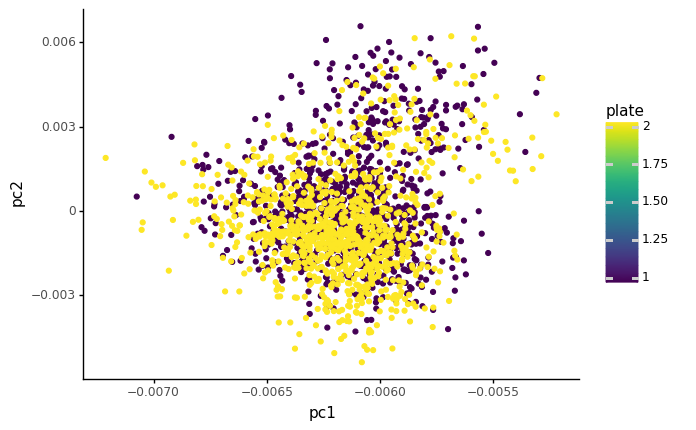

In [87]:
print(
    ggplot(df_bc[df_bc.experiment == 'VERO-1'], aes(x = 'pc1', y = 'pc2', colour = 'plate')) +
      theme_classic() +
      geom_point()
)

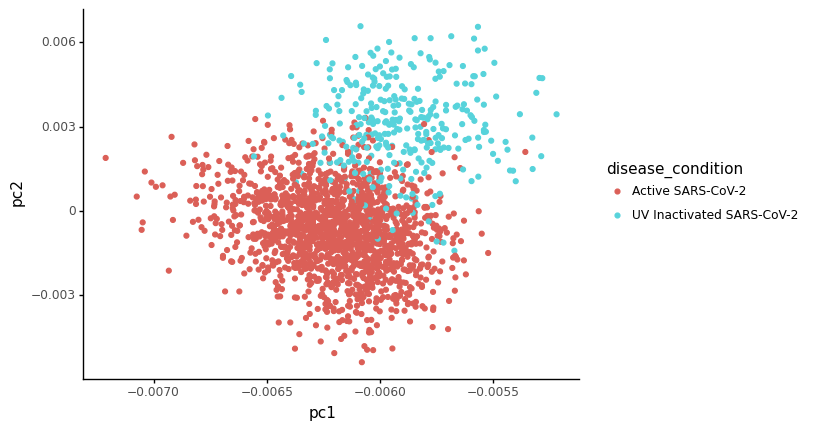

In [88]:
print(
    ggplot(df_bc[df_bc.experiment == 'VERO-1'], aes(x = 'pc1', y = 'pc2', colour = 'disease_condition')) +
      theme_classic() +
      geom_point()
)

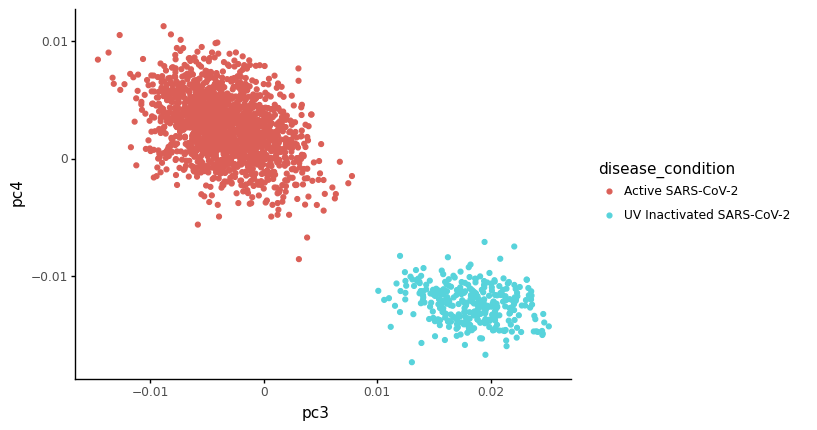

In [89]:
print(
    ggplot(df_bc[df_bc.experiment == 'VERO-1'], aes(x = 'pc3', y = 'pc4', colour = 'disease_condition')) +
      theme_classic() +
      geom_point()
)

## Split data into training and testing

In [91]:
labels = pheno.disease_condition.to_numpy()
features_m = features.to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(features_m, labels, test_size = 0.3, random_state=1334)

In [92]:
pheno['plate_well'] = (pheno.plate.to_string() + '_') + pheno.well
pheno.plate_well

0        0         1\n1         1\n2         1\n3      ...
1        0         1\n1         1\n2         1\n3      ...
2        0         1\n1         1\n2         1\n3      ...
3        0         1\n1         1\n2         1\n3      ...
4        0         1\n1         1\n2         1\n3      ...
                               ...                        
26307    0         1\n1         1\n2         1\n3      ...
26308    0         1\n1         1\n2         1\n3      ...
26309    0         1\n1         1\n2         1\n3      ...
26310    0         1\n1         1\n2         1\n3      ...
26311    0         1\n1         1\n2         1\n3      ...
Name: plate_well, Length: 26312, dtype: object

In [ ]:
plate_well = pheno.plate_well.to_numpy()
random.shuffle(plate_well)


In [ ]:

plate_well_train = plate_well[:18418]
plate_well_test = plate_well[18418:]

In [ ]:
float(plate_well.shape[0]) * 0.7

In [ ]:
idx_train = pheno['plate_well'].isin(plate_well_train)
idx_test = pheno['plate_well'].isin(plate_well_test)

In [ ]:
pheno_train = pheno[idx_train]
pheno_test = pheno[idx_test]

features_train = features[idx_train]
features_test = features[idx_test]

In [ ]:
X_train = features_train.to_numpy()
y_train, class_names = pd.factorize(pheno_train['disease_condition'])
X_test = features_test.to_numpy()
y_test, class_names = pd.factorize(pheno_test['disease_condition'])

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
class_names